In [1]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# https://medium.com/@thevnotebook/introduction-to-natural-language-processing-with-pytorch-1-5-83691a0e1d5f
# https://www.datacamp.com/tutorial/nlp-with-pytorch-a-comprehensive-guide -> sentimental classification
# https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm
# https://pytorch.org/docs/stable/torch.html#indexing-slicing-joining-mutating-ops


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set seed for reproducibility

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
# !unzip data.zip

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


In [9]:
print(dir(input_lang))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'addSentence', 'addWord', 'index2word', 'n_words', 'name', 'word2count', 'word2index']


In [10]:
print(random.choice(pairs))

['nous craignons de manquer notre train', 'we re afraid we ll miss our train']


In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [13]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
# plt.switch_backend('TkAgg')

import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [16]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [17]:
from tqdm import tqdm

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in tqdm(range(1, n_epochs + 1), desc='Training', unit='epoch', total=n_epochs):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [18]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [20]:
from torchinfo import summary

hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


In [21]:
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)


In [22]:
input_ids, target_ids = next(iter(train_dataloader))
print(input_ids.size(), input_ids.shape)
summary(encoder, input_data=input_ids, 
        col_names=["input_size", "output_size", "num_params", "params_percent",], 
        # verbose=2,
        col_width=20)

torch.Size([32, 10]) torch.Size([32, 10])


Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Param %
EncoderRNN                               [32, 10]             [32, 10, 128]        --                        --
├─Embedding: 1-1                         [32, 10]             [32, 10, 128]        588,928               85.60%
├─Dropout: 1-2                           [32, 10, 128]        [32, 10, 128]        --                        --
├─GRU: 1-3                               [32, 10, 128]        [32, 10, 128]        99,072                14.40%
Total params: 688,000
Trainable params: 688,000
Non-trainable params: 0
Total mult-adds (M): 50.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.66
Params size (MB): 2.75
Estimated Total Size (MB): 3.41

In [23]:
encoder_outputs, encoder_hidden = encoder(input_ids)
print(encoder_outputs.size(), encoder_hidden.size(), target_ids.size())
summary(decoder, 
        input_data=(encoder_outputs, encoder_hidden, target_ids),
        col_names=["input_size", "output_size", "num_params", "params_percent",], 
        # verbose=2,
        col_width=20)

torch.Size([32, 10, 128]) torch.Size([1, 32, 128]) torch.Size([32, 10])


Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Param %
AttnDecoderRNN                           [32, 10, 128]        [32, 10, 2991]       --                        --
├─Embedding: 1-1                         [32, 1]              [32, 1, 128]         382,848               40.30%
├─Dropout: 1-2                           [32, 1, 128]         [32, 1, 128]         --                        --
├─BahdanauAttention: 1-3                 [32, 1, 128]         [32, 1, 128]         --                        --
│    └─Linear: 2-1                       [32, 1, 128]         [32, 1, 128]         16,512                 1.74%
│    └─Linear: 2-2                       [32, 10, 128]        [32, 10, 128]        16,512                 1.74%
│    └─Linear: 2-3                       [32, 10, 128]        [32, 10, 1]          129                    0.01%
├─GRU: 1-4                               [32, 1, 256]         [32, 1, 128]         148,224              

Training:   6%|▋         | 5/80 [00:45<11:36,  9.29s/epoch]

0m 45s (- 11m 21s) (5 6%) 1.5273


Training:  12%|█▎        | 10/80 [01:32<11:08,  9.55s/epoch]

1m 33s (- 10m 51s) (10 12%) 0.6796


Training:  19%|█▉        | 15/80 [02:18<09:48,  9.05s/epoch]

2m 18s (- 10m 0s) (15 18%) 0.3500


Training:  25%|██▌       | 20/80 [03:03<08:14,  8.25s/epoch]

3m 3s (- 9m 10s) (20 25%) 0.1939


Training:  31%|███▏      | 25/80 [03:49<08:22,  9.13s/epoch]

3m 50s (- 8m 26s) (25 31%) 0.1194


Training:  38%|███▊      | 30/80 [04:45<09:06, 10.92s/epoch]

4m 45s (- 7m 56s) (30 37%) 0.0835


Training:  44%|████▍     | 35/80 [05:38<07:55, 10.56s/epoch]

5m 38s (- 7m 14s) (35 43%) 0.0643


Training:  50%|█████     | 40/80 [06:31<06:44, 10.11s/epoch]

6m 31s (- 6m 31s) (40 50%) 0.0525


Training:  56%|█████▋    | 45/80 [07:15<05:23,  9.23s/epoch]

7m 15s (- 5m 38s) (45 56%) 0.0458


Training:  62%|██████▎   | 50/80 [08:07<05:08, 10.27s/epoch]

8m 7s (- 4m 52s) (50 62%) 0.0403


Training:  69%|██████▉   | 55/80 [08:54<03:53,  9.35s/epoch]

8m 55s (- 4m 3s) (55 68%) 0.0377


Training:  75%|███████▌  | 60/80 [09:36<02:47,  8.36s/epoch]

9m 36s (- 3m 12s) (60 75%) 0.0347


Training:  81%|████████▏ | 65/80 [10:19<02:13,  8.89s/epoch]

10m 19s (- 2m 22s) (65 81%) 0.0331


Training:  88%|████████▊ | 70/80 [11:13<01:43, 10.32s/epoch]

11m 13s (- 1m 36s) (70 87%) 0.0312


Training:  94%|█████████▍| 75/80 [11:49<00:39,  7.82s/epoch]

11m 49s (- 0m 47s) (75 93%) 0.0303


Training: 100%|██████████| 80/80 [12:33<00:00,  9.41s/epoch]

12m 33s (- 0m 0s) (80 100%) 0.0288


<Figure size 640x480 with 0 Axes>

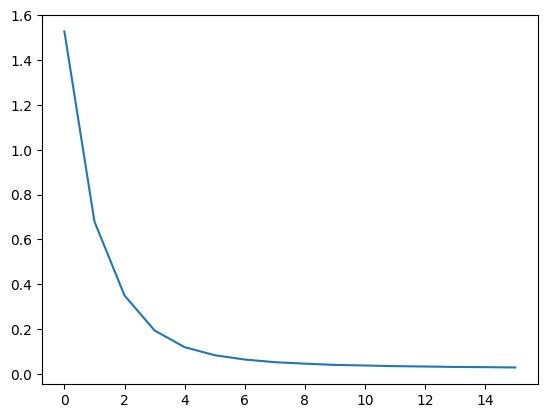

In [24]:
train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

In [25]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> je suis myope
= i m nearsighted
< i m nearsighted <EOS>

> ils sont vieux
= they re old
< they re old <EOS>

> nous sommes toutes differentes
= we re all different
< we re all different ! <EOS>

> vous etes sur la liste
= you re on the list
< you re on the list <EOS>

> je saigne gravement
= i m bleeding badly
< i m bleeding badly <EOS>

> il n est pas parfait
= he isn t perfect
< he s not perfect <EOS>

> tu es egoiste
= you re selfish
< you re selfish <EOS>

> aujourd hui elle va beaucoup mieux qu hier
= she s much better today than yesterday
< she s much better today than yesterday <EOS>

> ils courent dans le parc
= they are running in the park
< they are running in the park <EOS>

> je ne suis pas normal
= i m not normal
< i m not normal <EOS>



In [26]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


/tmp/ipykernel_6202/2731457559.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_6202/2731457559.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


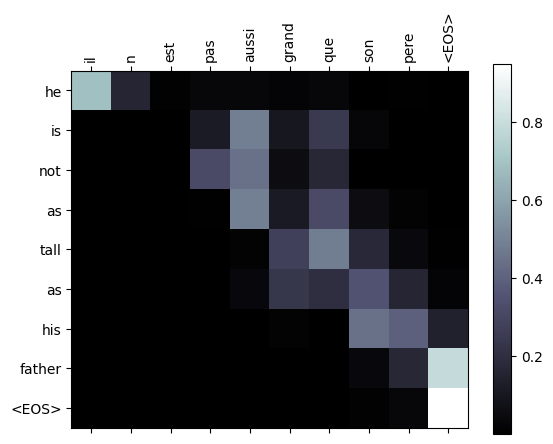

In [27]:
evaluateAndShowAttention('il n est pas aussi grand que son pere')

input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


/tmp/ipykernel_6202/2731457559.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_6202/2731457559.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


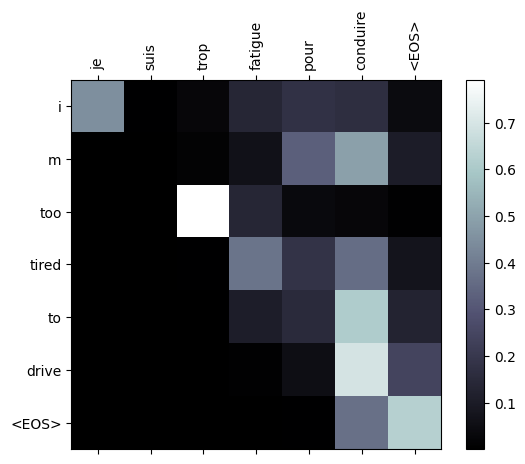

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


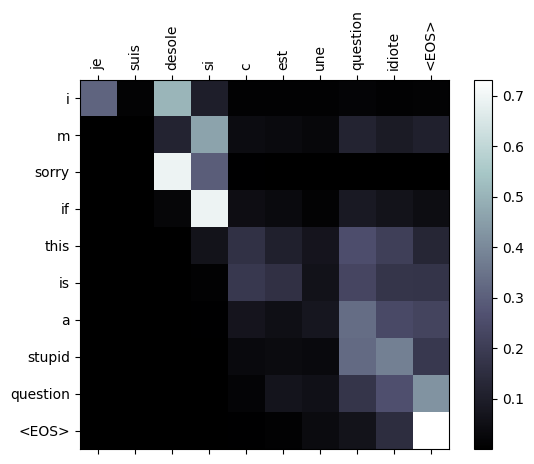

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


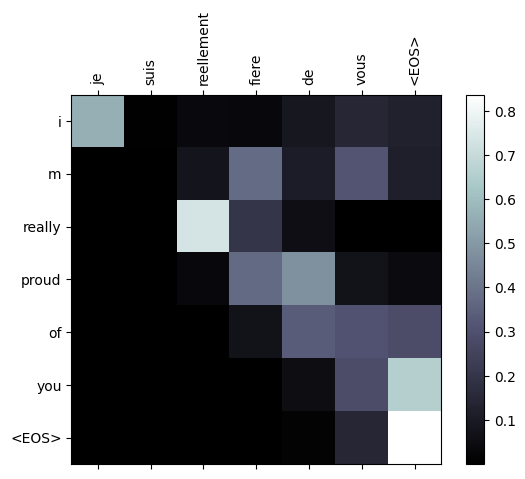

In [28]:
evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')